## WALMART STORE SALES PREDICTION - FORECASTING 
###### Definition of Target and Outcome Window
        - The objective is predicting store sales using historical markdown data.One challenge of modelling retail data is the              need to make decisions based on limited history. 
        - If Christmas comes but once a year, so does the chance to see how strategic decisions impacted the bottom line.
        - Our objective is to predict department-wide sales of each store.
 
###### Data Pre-Processing - 
    - Merging datasets
    - Missing Values Treatment (At Store and Department level)
    - Univariate Analysis - Outlier analysis
    
###### Data Exploratory Analysis
    - Detecting and converting zeros and negative to missing
    - Analyzing 4 major given holidays and weekly sales trend with repect to week no.
    - Bivariate Analysis - Correaltion with target variable
    - Variable Reduction - VIF

###### Model Build and Model Evaluation
    - Train and Test split
    - Model used :- Linear Regression, Random Forest Regressor, Gradient Boosting Regressor, Lasso Regressor,                                         K Neighbors Regressor, XGB Regressor, Extra Tree Regressor
    - Testing Parameters:- MAE(Mean Absolute Error), MSE(Mean Square Error) 
    - Scoring:- R2

###### Submission of final test predictions.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
# import pandas_profiling as pp
import matplotlib.pyplot as plt
# import statsmodels.api as sm
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
import datetime as dt
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
%matplotlib inline

#Models
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

#To calculate time
!pip install ipython-autotime
%load_ext autotime

## Importing data 

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
feat = pd.read_csv('features.csv')
store = pd.read_csv('stores.csv')

time: 234 ms


In [3]:
train.sample(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday
1714,1,12,2012-10-19,10830.48,False
366911,39,49,2010-04-09,7056.36,False
345306,36,90,2011-09-23,31737.98,False
402797,43,80,2011-08-26,15737.70,False
421036,45,94,2010-09-17,5760.43,False


time: 28.8 ms


In [4]:
test.sample(5)

,Store,Dept,Date,IsHoliday
114630,45,82,2013-06-28,False
79742,30,91,2013-06-28,False
14639,6,36,2013-03-15,False
74773,28,71,2013-04-26,False
96718,38,10,2013-02-08,True


time: 14 ms


In [5]:
store.sample(5)

,Store,Type,Size
17,18,B,120653
23,24,A,203819
13,14,A,200898
26,27,A,204184
7,8,A,155078


time: 7.95 ms


In [6]:
feat.sample(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
3538,20,2011-08-19,71.25,3.747,NaN,NaN,NaN,NaN,NaN,208.842436,7.274,False
4349,24,2013-03-22,31.29,3.999,3691.42,NaN,716.0,573.07,1693.38,138.925484,8.750,False
3167,18,2011-07-01,69.75,3.815,NaN,NaN,NaN,NaN,NaN,135.446800,8.890,False
5890,33,2011-05-13,78.24,4.202,NaN,NaN,NaN,NaN,NaN,129.089000,8.687,False
3840,22,2010-06-11,65.01,2.830,NaN,NaN,NaN,NaN,NaN,136.287426,8.348,False


time: 14 ms


## Data Pre-processing

#### Merging train, test with store and feature 

In [7]:
train = pd.merge(train,store,how='inner',on =['Store'])

time: 96.7 ms


In [8]:
train

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315
...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221
421566,45,98,2012-10-05,628.10,False,B,118221
421567,45,98,2012-10-12,1061.02,False,B,118221
421568,45,98,2012-10-19,760.01,False,B,118221


time: 19 ms


In [9]:
test = pd.merge(test,store,how='inner',on =['Store'])

time: 17 ms


In [10]:
test

,Store,Dept,Date,IsHoliday,Type,Size
0,1,1,2012-11-02,False,A,151315
1,1,1,2012-11-09,False,A,151315
2,1,1,2012-11-16,False,A,151315
3,1,1,2012-11-23,True,A,151315
4,1,1,2012-11-30,False,A,151315
...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,B,118221
115060,45,98,2013-07-05,False,B,118221
115061,45,98,2013-07-12,False,B,118221
115062,45,98,2013-07-19,False,B,118221


time: 18.9 ms


In [11]:
train = pd.merge(train,feat,how='inner',on =['Store','Date','IsHoliday'])

time: 159 ms


In [12]:
train

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667
421566,45,94,2012-10-26,5203.31,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667
421567,45,95,2012-10-26,56017.47,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667
421568,45,97,2012-10-26,6817.48,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667


time: 26 ms


In [13]:
test = pd.merge(test,feat,how='inner',on =['Store','Date','IsHoliday'])

time: 32.9 ms


In [14]:
test

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573
1,1,2,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573
2,1,3,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573
3,1,4,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573
4,1,5,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,93,2013-07-26,False,B,118221,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN
115060,45,94,2013-07-26,False,B,118221,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN
115061,45,95,2013-07-26,False,B,118221,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN
115062,45,97,2013-07-26,False,B,118221,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN


time: 23.9 ms


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       150681 non-null float64
MarkDown2       111248 non-null float64
MarkDown3       137091 non-null float64
MarkDown4       134967 non-null float64
MarkDown5       151432 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB
time: 139 ms


#### Missing value Treatment (Exception - Markdown 1-5)

In [16]:
train.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64

time: 52.9 ms


In [17]:
test.isna().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Type                0
Size                0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
dtype: int64

time: 22.9 ms


In [18]:
test.CPI = test.groupby(['Store','Dept'])['CPI'].transform(lambda x: x.fillna(x.mean()))
test.Unemployment = test.groupby(['Store','Dept'])['Unemployment'].transform(lambda x: x.fillna(x.mean()))
test.isna().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Type                0
Size                0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI                53
Unemployment       53
dtype: int64

time: 2.22 s


    A few rows are still null because all the rows in particular store dept combination have null values in CPI feature. Hence taking a mean at store level to fix the missing values.

In [19]:
test.CPI = test.groupby('Store')['CPI'].transform(lambda x: x.fillna(x.mean()))
test.Unemployment = test.groupby('Store')['Unemployment'].transform(lambda x: x.fillna(x.mean()))
test.isna().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Type                0
Size                0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI                 0
Unemployment        0
dtype: int64

time: 67.8 ms


## Exploratory data analysis

#### Extracting Year, Month, Week and Quarter from Date

In [20]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

time: 98.7 ms


In [21]:
train['month'] = pd.to_datetime(train['Date']).dt.month
train['year'] = pd.to_datetime(train['Date']).dt.year
train['week'] = pd.to_datetime(train['Date']).dt.week
train['quarter'] = pd.to_datetime(train['Date']).dt.quarter

time: 187 ms


In [22]:
train

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,month,year,week,quarter
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2,2010,5,1
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2,2010,5,1
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2,2010,5,1
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2,2010,5,1
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2,2010,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,10,2012,43,4
421566,45,94,2012-10-26,5203.31,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,10,2012,43,4
421567,45,95,2012-10-26,56017.47,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,10,2012,43,4
421568,45,97,2012-10-26,6817.48,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,10,2012,43,4


time: 39.9 ms


In [23]:
test['month'] = pd.to_datetime(test['Date']).dt.month
test['year'] = pd.to_datetime(test['Date']).dt.year
test['week'] = pd.to_datetime(test['Date']).dt.week
test['quarter'] = pd.to_datetime(test['Date']).dt.quarter

time: 54.9 ms


In [24]:
test

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,month,year,week,quarter
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573000,11,2012,44,4
1,1,2,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573000,11,2012,44,4
2,1,3,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573000,11,2012,44,4
3,1,4,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573000,11,2012,44,4
4,1,5,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573000,11,2012,44,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,93,2013-07-26,False,B,118221,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,192.870729,8.594923,7,2013,30,3
115060,45,94,2013-07-26,False,B,118221,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,192.870729,8.594923,7,2013,30,3
115061,45,95,2013-07-26,False,B,118221,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,192.870729,8.594923,7,2013,30,3
115062,45,97,2013-07-26,False,B,118221,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,192.870729,8.594923,7,2013,30,3


time: 22 ms


#### Extracting given 4 major holidays

In [25]:
Super_Bowl= ['2010-02-12', '2011-02-11', '2012-02-10','2013-02-08']
Labor_Day= ['2010-09-10', '2011-09-9', '2012-09-07', '2013-09-06']
Thanksgiving= ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29']
Christmas=['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']

time: 997 µs


##### Train 

In [26]:
train.IsHoliday.value_counts()

False    391909
True      29661
Name: IsHoliday, dtype: int64

time: 19.9 ms


In [27]:
train['Super_Bowl']=train[(train.Date == Super_Bowl[0]) | (train.Date == Super_Bowl[1]) | (train.Date == Super_Bowl[2]) | (train.Date == Super_Bowl[3]) ].IsHoliday
train['Super_Bowl'].fillna(0,inplace=True)
train['Super_Bowl'].replace(to_replace=True,value=1,inplace=True)
train['Super_Bowl'].value_counts()

0    412675
1      8895
Name: Super_Bowl, dtype: int64

time: 332 ms


In [28]:
train['Labor_Day']=train[(train.Date == Labor_Day[0]) | (train.Date == Labor_Day[1]) | (train.Date == Labor_Day[2]) | (train.Date == Labor_Day[3]) ].IsHoliday
train['Labor_Day'].fillna(0,inplace=True)
train['Labor_Day'].replace(to_replace=True,value=1,inplace=True)
train['Labor_Day'].value_counts()

0    412709
1      8861
Name: Labor_Day, dtype: int64

time: 311 ms


In [29]:
train['Thanksgiving']=train[(train.Date == Thanksgiving[0]) | (train.Date == Thanksgiving[1]) | (train.Date == Thanksgiving[2]) | (train.Date == Thanksgiving[3]) ].IsHoliday
train['Thanksgiving'].fillna(0,inplace=True)
train['Thanksgiving'].replace(to_replace=True,value=1,inplace=True)
train['Thanksgiving'].value_counts()

0    415611
1      5959
Name: Thanksgiving, dtype: int64

time: 289 ms


In [30]:
train['Christmas']=train[(train.Date == Christmas[0]) | (train.Date == Christmas[1]) | (train.Date == Christmas[2]) | (train.Date == Christmas[3]) ].IsHoliday
train['Christmas'].fillna(0,inplace=True)
train['Christmas'].replace(to_replace=True,value=1,inplace=True)
train['Christmas'].value_counts()

0    415624
1      5946
Name: Christmas, dtype: int64

time: 328 ms


In [31]:
train.groupby(['Super_Bowl','Labor_Day','Thanksgiving','Christmas']).IsHoliday.value_counts()

Super_Bowl  Labor_Day  Thanksgiving  Christmas  IsHoliday
0           0          0             0          False        391909
                                     1          True           5946
                       1             0          True           5959
            1          0             0          True           8861
1           0          0             0          True           8895
Name: IsHoliday, dtype: int64

time: 173 ms


##### Test 

In [32]:
test.IsHoliday.value_counts()

False    106136
True       8928
Name: IsHoliday, dtype: int64

time: 6.98 ms


In [33]:
test['Super_Bowl']=test[(test.Date == Super_Bowl[0]) | (test.Date == Super_Bowl[1]) | (test.Date == Super_Bowl[2]) | (test.Date == Super_Bowl[3]) ].IsHoliday
test['Super_Bowl'].fillna(0,inplace=True)
test['Super_Bowl'].replace(to_replace=True,value=1,inplace=True)
test['Super_Bowl'].value_counts()

0    112100
1      2964
Name: Super_Bowl, dtype: int64

time: 116 ms


In [34]:
test['Labor_Day']=test[(test.Date == Labor_Day[0]) | (test.Date == Labor_Day[1]) | (test.Date == Labor_Day[2]) | (test.Date == Labor_Day[3]) ].IsHoliday
test['Labor_Day'].fillna(0,inplace=True)
test['Labor_Day'].replace(to_replace=True,value=1,inplace=True)
test['Labor_Day'].value_counts()

0    115064
Name: Labor_Day, dtype: int64

time: 69.8 ms


In [35]:
test['Thanksgiving']=test[(test.Date == Thanksgiving[0]) | (test.Date == Thanksgiving[1]) | (test.Date == Thanksgiving[2]) | (test.Date == Thanksgiving[3]) ].IsHoliday
test['Thanksgiving'].fillna(0,inplace=True)
test['Thanksgiving'].replace(to_replace=True,value=1,inplace=True)
test['Thanksgiving'].value_counts()

0    112088
1      2976
Name: Thanksgiving, dtype: int64

time: 102 ms


In [36]:
test['Christmas']=test[(test.Date == Christmas[0]) | (test.Date == Christmas[1]) | (test.Date == Christmas[2]) | (test.Date == Christmas[3]) ].IsHoliday
test['Christmas'].fillna(0,inplace=True)
test['Christmas'].replace(to_replace=True,value=1,inplace=True)
test['Christmas'].value_counts()

0    112076
1      2988
Name: Christmas, dtype: int64

time: 101 ms


In [37]:
test.groupby(['Super_Bowl','Labor_Day','Thanksgiving','Christmas']).IsHoliday.value_counts()

Super_Bowl  Labor_Day  Thanksgiving  Christmas  IsHoliday
0           0          0             0          False        106136
                                     1          True           2988
                       1             0          True           2976
1           0          0             0          True           2964
Name: IsHoliday, dtype: int64

time: 48.9 ms


    From above we can conclude that IsHoliday contains all the holidays including the 4 major holidays.

In [38]:
#Replacing True and False 1 and 0 for train and test
train.IsHoliday.replace(to_replace=True,value=1,inplace=True)
train.IsHoliday.replace(to_replace=False,value=0,inplace=True)

test.IsHoliday.replace(to_replace=True,value=1,inplace=True)
test.IsHoliday.replace(to_replace=False,value=0,inplace=True)

train.IsHoliday = train.IsHoliday.astype('int32')
test.IsHoliday = test.IsHoliday.astype('int32')

time: 152 ms


### Exploring the weekly sales trend with respect to week number

In [39]:
train.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'month', 'year',
       'week', 'quarter', 'Super_Bowl', 'Labor_Day', 'Thanksgiving',
       'Christmas'],
      dtype='object')

time: 4.98 ms


Text(0.5, 0, 'Week')

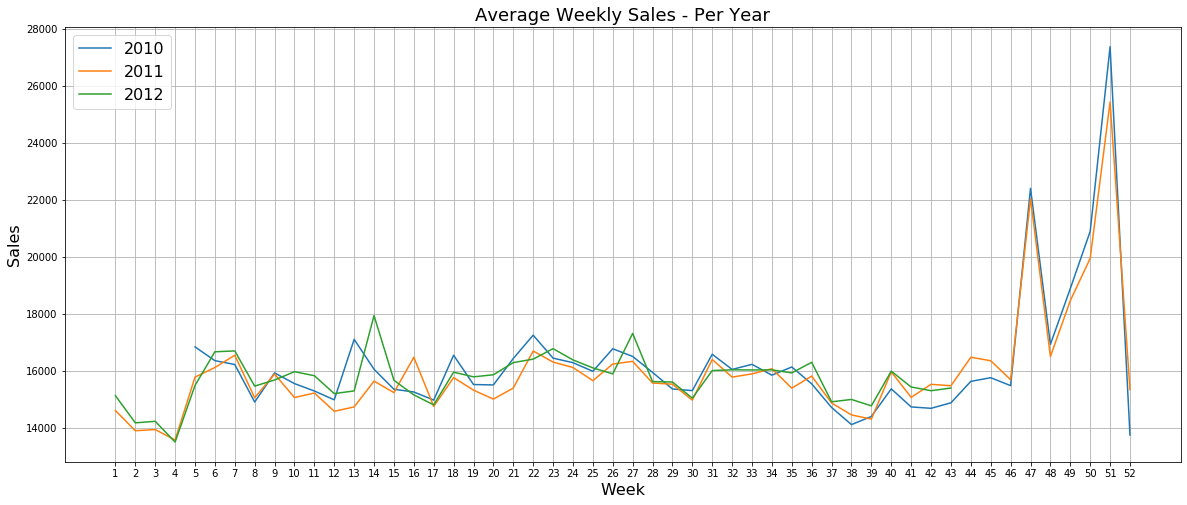

time: 732 ms


In [40]:
weekly_sales_2010 = train[train.year==2010]['Weekly_Sales'].groupby(train['week']).mean()
weekly_sales_2011 = train[train.year==2011]['Weekly_Sales'].groupby(train['week']).mean()
weekly_sales_2012 = train[train.year==2012]['Weekly_Sales'].groupby(train['week']).mean()
weekly_sales_2012
plt.figure(figsize=(20,8))
sb.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sb.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sb.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)

In [41]:
train[(train.week==13) | (train.week==14) | (train.week==16)].Date.value_counts()

2012-04-06    2983
2012-04-20    2975
2012-03-30    2961
2011-04-22    2955
2010-04-09    2951
2011-04-01    2951
2010-04-02    2949
2011-04-08    2935
2010-04-23    2933
Name: Date, dtype: int64

time: 17 ms


In [42]:
test[(test.week==13) | (test.week==14) | (test.week==16)].Date.value_counts()

2013-04-19    2948
2013-04-05    2946
2013-03-29    2940
Name: Date, dtype: int64

time: 9.97 ms


    A little spike in sales can be observed during week 14 of year 2012. This week another Holiday is observed i.e. Easter. 
    This Holiday is not present in our Holiday list. Thus, will use it to find modify IsHoliday attribute.

In [43]:
print(train.IsHoliday.value_counts())
print(test.IsHoliday.value_counts())

0    391909
1     29661
Name: IsHoliday, dtype: int64
0    106136
1      8928
Name: IsHoliday, dtype: int64
time: 12 ms


In [44]:
train.loc[(train.year==2010) & (train.week==13), 'IsHoliday'] = 1
train.loc[(train.year==2011) & (train.week==16), 'IsHoliday'] = 1
train.loc[(train.year==2012) & (train.week==14), 'IsHoliday'] = 1
test.loc[(test.year==2013) & (test.week==13), 'IsHoliday'] = 1

time: 62.8 ms


In [45]:
print(train.IsHoliday.value_counts())
print(test.IsHoliday.value_counts())

0    383022
1     38548
Name: IsHoliday, dtype: int64
0    103196
1     11868
Name: IsHoliday, dtype: int64
time: 18 ms


In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 24 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null datetime64[ns]
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null int32
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       150681 non-null float64
MarkDown2       111248 non-null float64
MarkDown3       137091 non-null float64
MarkDown4       134967 non-null float64
MarkDown5       151432 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
month           421570 non-null int64
year            421570 non-null int64
week            421570 non-null int64
quarter         421570 non-null int64
Super_Bowl      421570 non-null int64
Labor_Day       421570 non-null int64
Thanksgiving    421570 

In [47]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 23 columns):
Store           115064 non-null int64
Dept            115064 non-null int64
Date            115064 non-null datetime64[ns]
IsHoliday       115064 non-null int32
Type            115064 non-null object
Size            115064 non-null int64
Temperature     115064 non-null float64
Fuel_Price      115064 non-null float64
MarkDown1       114915 non-null float64
MarkDown2       86437 non-null float64
MarkDown3       105235 non-null float64
MarkDown4       102176 non-null float64
MarkDown5       115064 non-null float64
CPI             115064 non-null float64
Unemployment    115064 non-null float64
month           115064 non-null int64
year            115064 non-null int64
week            115064 non-null int64
quarter         115064 non-null int64
Super_Bowl      115064 non-null int64
Labor_Day       115064 non-null int64
Thanksgiving    115064 non-null int64
Christmas       115064 non

In [48]:
train_org = train.copy(deep=True)
test_org = test.copy(deep=True)

time: 64.8 ms


### Dropping columns that are not needed further

In [49]:
train.drop(columns=['Date','Super_Bowl','Labor_Day','Thanksgiving','Christmas','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],inplace=True)
test.drop(columns=['Date','Super_Bowl','Labor_Day','Thanksgiving','Christmas','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],inplace=True)

time: 43.9 ms


## Splitting data into numeric and categorical

In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 14 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null int32
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
month           421570 non-null int64
year            421570 non-null int64
week            421570 non-null int64
quarter         421570 non-null int64
dtypes: float64(5), int32(1), int64(7), object(1)
memory usage: 66.6+ MB
time: 53.9 ms


In [51]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 13 columns):
Store           115064 non-null int64
Dept            115064 non-null int64
IsHoliday       115064 non-null int32
Type            115064 non-null object
Size            115064 non-null int64
Temperature     115064 non-null float64
Fuel_Price      115064 non-null float64
CPI             115064 non-null float64
Unemployment    115064 non-null float64
month           115064 non-null int64
year            115064 non-null int64
week            115064 non-null int64
quarter         115064 non-null int64
dtypes: float64(4), int32(1), int64(7), object(1)
memory usage: 11.9+ MB
time: 16 ms


In [52]:
cat_list = ['Type','Store','Dept','month','week','quarter','year','IsHoliday']

train_cat = train[cat_list] 
train_num = train[train.columns.difference(cat_list)]

test_cat = test[cat_list]
test_num = test[test.columns.difference(cat_list)]

time: 41.9 ms


In [53]:
train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 8 columns):
Type         421570 non-null object
Store        421570 non-null int64
Dept         421570 non-null int64
month        421570 non-null int64
week         421570 non-null int64
quarter      421570 non-null int64
year         421570 non-null int64
IsHoliday    421570 non-null int32
dtypes: int32(1), int64(6), object(1)
memory usage: 47.3+ MB
time: 27.9 ms


In [54]:
train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 6 columns):
CPI             421570 non-null float64
Fuel_Price      421570 non-null float64
Size            421570 non-null int64
Temperature     421570 non-null float64
Unemployment    421570 non-null float64
Weekly_Sales    421570 non-null float64
dtypes: float64(5), int64(1)
memory usage: 42.5 MB
time: 15 ms


In [55]:
test_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 8 columns):
Type         115064 non-null object
Store        115064 non-null int64
Dept         115064 non-null int64
month        115064 non-null int64
week         115064 non-null int64
quarter      115064 non-null int64
year         115064 non-null int64
IsHoliday    115064 non-null int32
dtypes: int32(1), int64(6), object(1)
memory usage: 7.5+ MB
time: 9.97 ms


In [56]:
test_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 5 columns):
CPI             115064 non-null float64
Fuel_Price      115064 non-null float64
Size            115064 non-null int64
Temperature     115064 non-null float64
Unemployment    115064 non-null float64
dtypes: float64(4), int64(1)
memory usage: 5.3 MB
time: 8.98 ms


### Numerical

#### Data Audit report

In [57]:
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

time: 8.98 ms


In [58]:
train_num.apply(lambda x: var_summary(x)).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
CPI,421570.0,0.0,7.217360e+07,171.201947,182.31878,39.159276,1.533449e+03,126.064,126.111903,126.496258,128.823806,132.022667,182.31878,212.416993,219.444244,221.941558,225.473509,227.232807
Fuel_Price,421570.0,0.0,1.416908e+06,3.361027,3.45200,0.458515,2.102356e-01,2.472,2.565000,2.653000,2.720000,2.933000,3.45200,3.738000,3.917000,4.029000,4.202000,4.468000
Size,421570.0,0.0,5.764039e+10,136727.915739,140167.00000,60980.583328,3.718632e+09,34875.000,34875.000000,39690.000000,39910.000000,93638.000000,140167.00000,202505.000000,204184.000000,206302.000000,219622.000000,219622.000000
Temperature,421570.0,0.0,2.533217e+07,60.090059,62.09000,18.447931,3.403262e+02,-2.060,18.300000,27.310000,33.980000,46.680000,62.09000,74.280000,83.580000,87.270000,92.810000,100.140000
Unemployment,421570.0,0.0,3.355819e+06,7.960289,7.86600,1.863296,3.471872e+00,3.879,4.156000,5.326000,5.965000,6.891000,7.86600,8.572000,9.816000,12.187000,14.180000,14.313000
Weekly_Sales,421570.0,0.0,6.737219e+09,15981.258123,7612.03000,22711.183519,5.157979e+08,-4988.940,5.000000,59.974500,291.097000,2079.650000,7612.03000,20205.852500,42845.673000,61201.951000,106479.586000,693099.360000


time: 713 ms


In [59]:
test_num.apply(lambda x : var_summary(x)).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
CPI,115064.0,0.0,2.036046e+07,176.948975,192.358548,41.240627,1.700789e+03,131.236226,131.279355,131.747000,132.042912,138.424667,192.358548,223.244532,225.910250,227.832373,228.642888,228.976456
Fuel_Price,115064.0,0.0,4.121070e+05,3.581546,3.606000,0.239442,5.733244e-02,2.872000,2.957000,3.161000,3.227000,3.431000,3.606000,3.766000,3.866000,3.951000,4.079000,4.125000
Size,115064.0,0.0,1.570597e+10,136497.688921,140167.000000,61106.926438,3.734056e+09,34875.000000,34875.000000,39690.000000,39910.000000,93638.000000,140167.000000,202505.000000,204184.000000,206302.000000,219622.000000,219622.000000
Temperature,115064.0,0.0,6.206760e+06,53.941804,54.470000,18.724153,3.505939e+02,-7.290000,11.440000,23.980000,29.970000,39.820000,54.470000,67.350000,79.480000,83.820000,92.140000,101.950000
Unemployment,115064.0,0.0,7.904467e+05,6.869627,6.820192,1.581820,2.502155e+00,3.684000,3.879000,3.967577,5.046923,5.771000,6.820192,8.000000,8.879885,9.910000,10.199000,10.199000


time: 217 ms


##### Detecting and converting -ve and zeros to missing 

In [60]:
print('Before')
for i in train_num.columns.difference(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']):
    c = train_num[train_num[i] <= 0][i].count()
    print(i, c)

train_num.loc[(train_num.Temperature <=0),'Temperature'] = np.nan
train_num.loc[(train_num.Weekly_Sales <=0),'Weekly_Sales'] = np.nan

print('\nAfter')
for i in train_num.columns.difference(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']):
    d = train_num[train_num[i] <= 0][i].count()
    print(i, d)

train_num.apply(lambda x: var_summary(x)).T

Before
CPI 0
Fuel_Price 0
Size 0
Temperature 69
Unemployment 0
Weekly_Sales 1358

After
CPI 0
Fuel_Price 0
Size 0
Temperature 0
Unemployment 0
Weekly_Sales 0


C:\Users\chord\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
CPI,421570.0,0.0,7.217360e+07,171.201947,182.31878,39.159276,1.533449e+03,126.064,126.111903,126.496258,128.823806,132.022667,182.31878,212.416993,219.444244,221.941558,225.473509,227.232807
Fuel_Price,421570.0,0.0,1.416908e+06,3.361027,3.45200,0.458515,2.102356e-01,2.472,2.565000,2.653000,2.720000,2.933000,3.45200,3.738000,3.917000,4.029000,4.202000,4.468000
Size,421570.0,0.0,5.764039e+10,136727.915739,140167.00000,60980.583328,3.718632e+09,34875.000,34875.000000,39690.000000,39910.000000,93638.000000,140167.00000,202505.000000,204184.000000,206302.000000,219622.000000,219622.000000
Temperature,421501.0,69.0,2.533231e+07,60.100233,62.09000,18.432294,3.397495e+02,5.540,18.360000,27.310000,33.990000,46.700000,62.09000,74.280000,83.580000,87.270000,92.810000,100.140000
Unemployment,421570.0,0.0,3.355819e+06,7.960289,7.86600,1.863296,3.471872e+00,3.879,4.156000,5.326000,5.965000,6.891000,7.86600,8.572000,9.816000,12.187000,14.180000,14.313000
Weekly_Sales,420212.0,1358.0,6.737307e+09,16033.114591,7661.70000,22729.492116,5.166298e+08,0.010,7.440000,67.551000,311.186000,2120.130000,7661.70000,20271.265000,42922.748000,61275.522000,106566.351400,693099.360000


time: 768 ms


In [61]:
print('Before')
for i in test_num.columns.difference(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']):
    e = test_num[test[i] <= 0][i].count()
    print(i, e)

test_num.loc[test_num.Temperature <=0,'Temperature'] = np.nan

print('\nAfter')
for i in test_num.columns.difference(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']):
    f = test_num[test[i] <= 0][i].count()
    print(i, f)
    
test_num.apply(lambda x: var_summary(x)).T

Before
CPI 0
Fuel_Price 0
Size 0
Temperature 208
Unemployment 0

After
CPI 0
Fuel_Price 0
Size 0
Temperature 0
Unemployment 0


,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
CPI,115064.0,0.0,2.036046e+07,176.948975,192.358548,41.240627,1.700789e+03,131.236226,131.279355,131.747000,132.042912,138.424667,192.358548,223.244532,225.910250,227.832373,228.642888,228.976456
Fuel_Price,115064.0,0.0,4.121070e+05,3.581546,3.606000,0.239442,5.733244e-02,2.872000,2.957000,3.161000,3.227000,3.431000,3.606000,3.766000,3.866000,3.951000,4.079000,4.125000
Size,115064.0,0.0,1.570597e+10,136497.688921,140167.000000,61106.926438,3.734056e+09,34875.000000,34875.000000,39690.000000,39910.000000,93638.000000,140167.000000,202505.000000,204184.000000,206302.000000,219622.000000,219622.000000
Temperature,114856.0,208.0,6.208144e+06,54.051546,54.510000,18.562489,3.445660e+02,0.250000,12.140000,24.590000,30.070000,39.870000,54.510000,67.430000,79.480000,83.820000,92.140000,101.950000
Unemployment,115064.0,0.0,7.904467e+05,6.869627,6.820192,1.581820,2.502155e+00,3.684000,3.879000,3.967577,5.046923,5.771000,6.820192,8.000000,8.879885,9.910000,10.199000,10.199000


time: 245 ms


##### Fixing missing values

###### Train

In [62]:
train_num = pd.concat([train_num,train[['Store','Dept']]],axis=1)

time: 21.9 ms


In [63]:
train_num.isna().sum()

CPI                0
Fuel_Price         0
Size               0
Temperature       69
Unemployment       0
Weekly_Sales    1358
Store              0
Dept               0
dtype: int64

time: 70.8 ms


In [64]:
train_num['Temperature']=train_num.groupby(by=['Store','Dept']).Temperature.transform(lambda x: x.fillna(x.mean()))
train_num['Weekly_Sales']=train_num.groupby(by=['Store','Dept']).Weekly_Sales.transform(lambda x: x.fillna(x.mean()))

time: 2.62 s


In [65]:
train_num.isna().sum()

CPI              0
Fuel_Price       0
Size             0
Temperature      0
Unemployment     0
Weekly_Sales    19
Store            0
Dept             0
dtype: int64

time: 16 ms


In [66]:
# train_num-> Weekly_Sales still has 19 values with NaN, Hence, taking mean at store level
train_num['Weekly_Sales']=train_num.groupby(by=['Store']).Weekly_Sales.transform(lambda x: x.fillna(x.mean()))

time: 69.8 ms


In [67]:
train_num.isna().sum()

CPI             0
Fuel_Price      0
Size            0
Temperature     0
Unemployment    0
Weekly_Sales    0
Store           0
Dept            0
dtype: int64

time: 17 ms


###### Test

In [68]:
test_num = pd.concat([test_num,test[['Store','Dept']]],axis=1)

time: 6.98 ms


In [69]:
test_num.isna().sum()

CPI               0
Fuel_Price        0
Size              0
Temperature     208
Unemployment      0
Store             0
Dept              0
dtype: int64

time: 14 ms


In [70]:
test_num['Temperature']=test_num.groupby(by=['Store','Dept']).Temperature.transform(lambda x: x.fillna(x.mean()))

time: 1.26 s


In [71]:
test_num.isna().sum()

CPI             0
Fuel_Price      0
Size            0
Temperature     0
Unemployment    0
Store           0
Dept            0
dtype: int64

time: 6.98 ms


In [72]:
#store and dept not needed now hence dropping them from both train_num and test_num.
train_num.drop(columns=['Store','Dept'],axis=1,inplace=True)
test_num.drop(columns=['Store','Dept'],axis=1,inplace=True)

time: 17 ms


#### Visualizing outliers and distribution

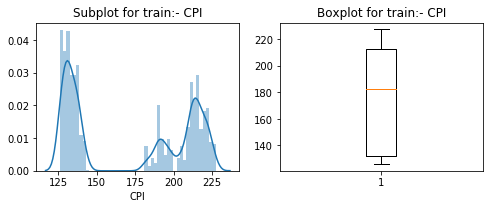

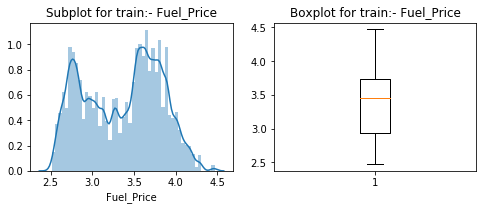

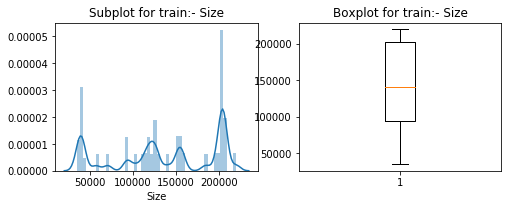

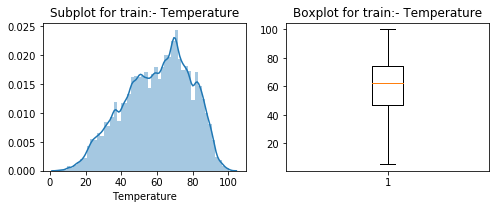

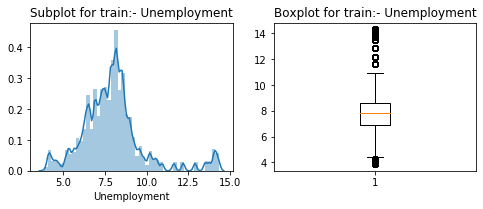

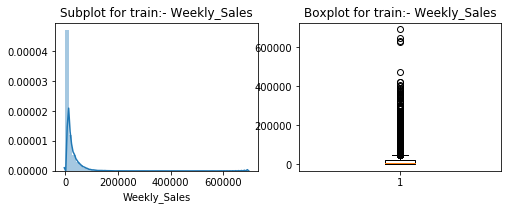

time: 2.23 s


In [73]:
# Train_num
for i in train_num.columns:
    plt.figure(figsize=(8,6))
    plt.subplot(2,2,1)
    sb.distplot(train_num[i])
    plt.title(str('Subplot for train:- ') + str(i))
    plt.subplot(2,2,2)
    plt.boxplot(train_num[i])
    plt.title(str('Boxplot for train:- ') + str(i))

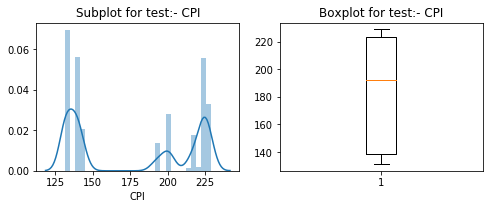

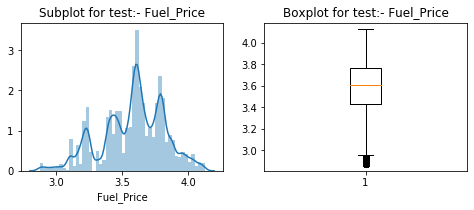

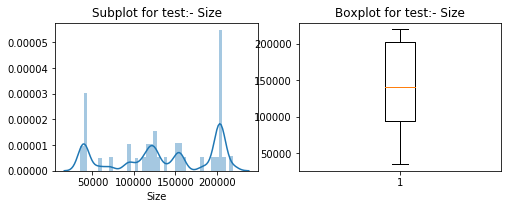

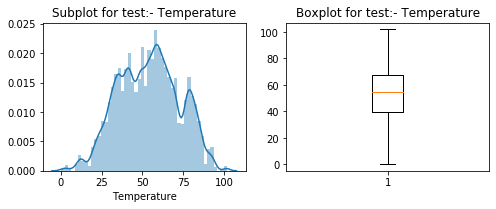

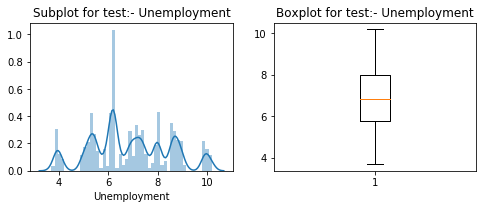

time: 1.49 s


In [74]:
#Test_num
for i in test_num.columns:
    plt.figure(figsize=(8,6))
    plt.subplot(2,2,1)
    sb.distplot(test_num[i])
    plt.title(str('Subplot for test:- ') + str(i))
    plt.subplot(2,2,2)
    plt.boxplot(test_num[i])
    plt.title(str('Boxplot for test:- ') + str(i))

##### Outlier treatment clipping at 10% and 90%

In [75]:
def outlier_capping(x):
    x = x.clip(upper = x.quantile(0.90))
    x = x.clip(lower = x.quantile(0.10))
    return x

time: 997 µs


In [76]:
train_num = train_num.apply(lambda x : outlier_capping(x))
test_num = test_num.apply(lambda x : outlier_capping(x))

time: 349 ms


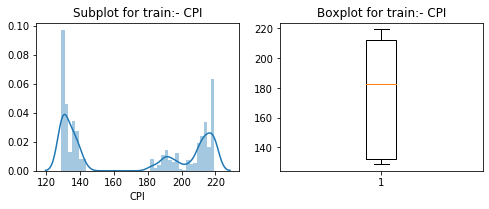

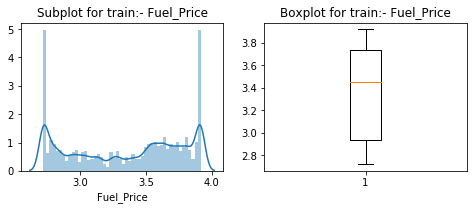

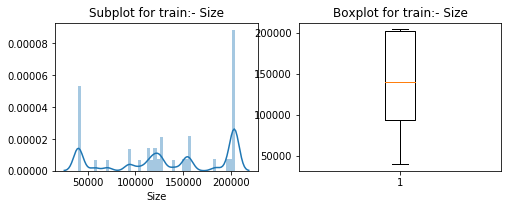

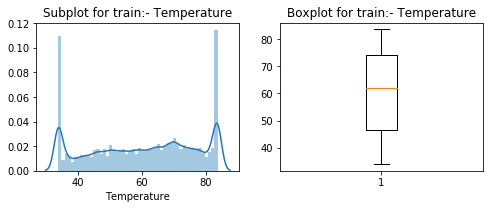

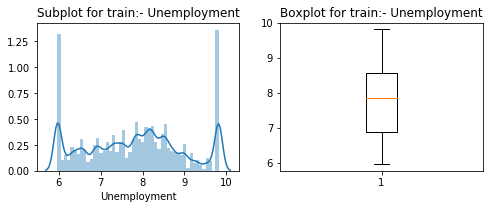

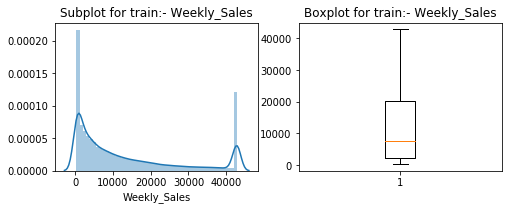

time: 2.14 s


In [77]:
#Train_num
for i in train_num.columns:
    plt.figure(figsize=(8,6))
    plt.subplot(2,2,1)
    sb.distplot(train_num[i])
    plt.title(str('Subplot for train:- ') + str(i))
    plt.subplot(2,2,2)
    plt.boxplot(train_num[i])
    plt.title(str('Boxplot for train:- ') + str(i))

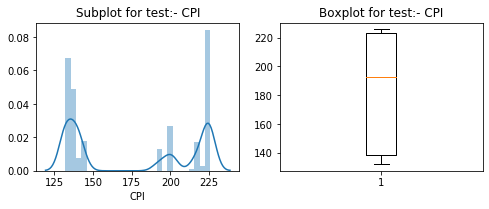

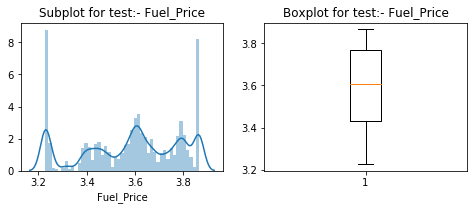

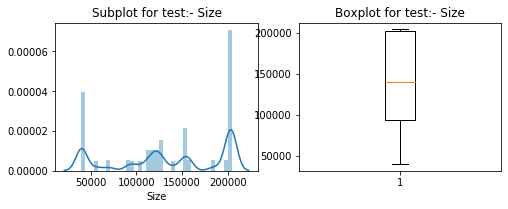

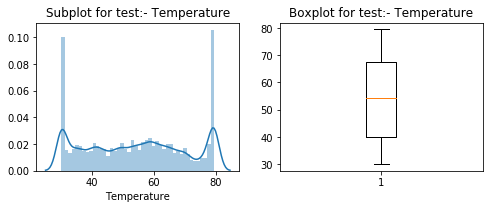

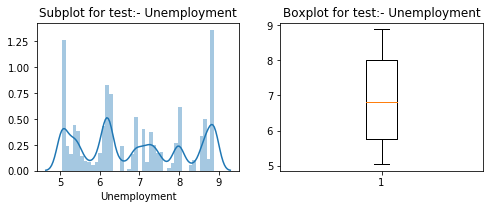

time: 1.35 s


In [78]:
#Test_num
for i in test_num.columns:
    plt.figure(figsize=(8,6))
    plt.subplot(2,2,1)
    sb.distplot(test_num[i])
    plt.title(str('Subplot for test:- ') + str(i))
    plt.subplot(2,2,2)
    plt.boxplot(test_num[i])
    plt.title(str('Boxplot for test:- ') + str(i))

### Categorical

In [79]:
def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()], 
                  index=['N', 'NMISS', 'ColumnsNames'])

time: 954 µs


In [80]:
train_cat.apply(lambda x: cat_summary(x))

,Type,Store,Dept,month,week,quarter,year,IsHoliday
N,421570,421570,421570,421570,421570,421570,421570,421570
NMISS,0,0,0,0,0,0,0,0
ColumnsNames,A 215478 B 163495 C 42597 Name: Type...,13 10474 10 10315 4 10272 1 1024...,1 6435 10 6435 38 6435 21 6435 67...,4 41332 7 40980 3 38451 10 3836...,7 8929 6 8895 10 8892 9 8892 15...,3 117488 2 114783 1 97522 4 9177...,2011 153453 2010 140679 2012 127438 N...,"0 383022 1 38548 Name: IsHoliday, dtype..."


time: 266 ms


In [81]:
test_cat.apply(lambda x: cat_summary(x))

,Type,Store,Dept,month,week,quarter,year,IsHoliday
N,115064,115064,115064,115064,115064,115064,115064,115064
NMISS,0,0,0,0,0,0,0,0
ColumnsNames,"A 58713 B 44500 C 11851 Name: Type, d...",13 2836 4 2803 19 2799 2 2797 27...,1 1755 13 1755 91 1755 90 1755 21...,11 14824 5 14726 3 14677 12 1196...,51 3002 49 2989 52 2988 50 2986 7 ...,1 38326 2 38217 4 26789 3 11732 Na...,"2013 88275 2012 26789 Name: year, dtype:...","0 103196 1 11868 Name: IsHoliday, dtype..."


time: 120 ms


    Missing values are not present in train and test set for category

#### Creating dummy variables

In [82]:
train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 8 columns):
Type         421570 non-null object
Store        421570 non-null int64
Dept         421570 non-null int64
month        421570 non-null int64
week         421570 non-null int64
quarter      421570 non-null int64
year         421570 non-null int64
IsHoliday    421570 non-null int32
dtypes: int32(1), int64(6), object(1)
memory usage: 47.3+ MB
time: 27.9 ms


In [83]:
train_cat_dum = pd.get_dummies(train_cat,prefix = train_cat.columns, prefix_sep='_', columns = train_cat.columns)

time: 563 ms


In [84]:
train_cat_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Columns: 202 entries, Type_A to IsHoliday_1
dtypes: uint8(202)
memory usage: 104.4 MB
time: 131 ms


In [85]:
test_cat_dum = pd.get_dummies(test_cat, prefix = test_cat.columns, prefix_sep='_', columns = test_cat.columns)

time: 183 ms


In [86]:
test_cat_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Columns: 185 entries, Type_A to IsHoliday_1
dtypes: uint8(185)
memory usage: 21.2 MB
time: 37.9 ms


In [87]:
train_cat_dum.columns.difference(test_cat_dum.columns.values).values

array(['month_10', 'month_8', 'month_9', 'week_31', 'week_32', 'week_33',
       'week_34', 'week_35', 'week_36', 'week_37', 'week_38', 'week_39',
       'week_40', 'week_41', 'week_42', 'week_43', 'year_2010',
       'year_2011'], dtype=object)

time: 1.99 ms


In [88]:
test_cat_dum.columns.difference(train_cat_dum.columns.values).values

array(['year_2013'], dtype=object)

time: 3.99 ms


In [89]:
del train_cat_dum
del test_cat_dum

time: 14 ms


In [90]:
train_cat_dum = pd.get_dummies(train_cat,prefix = train_cat.columns.difference(['IsHoliday','year','week','month']),prefix_sep='_', columns = train_cat.columns.difference(['IsHoliday','year','week','month']))

time: 433 ms


In [91]:
test_cat_dum = pd.get_dummies(test_cat,prefix = test_cat.columns.difference(['IsHoliday','year','week','month']),prefix_sep='_', columns = test_cat.columns.difference(['IsHoliday','year','week','month']))

time: 118 ms


In [92]:
train_cat_dum.columns.difference(test_cat_dum.columns.values).values

array([], dtype=object)

time: 4.99 ms


In [93]:
test_cat_dum.columns.difference(train_cat_dum.columns.values).values

array([], dtype=object)

time: 2.99 ms


### Combining datasets 

In [94]:
#Combining _num and _cat_dum
train_combo_dum = pd.concat([train_num,train_cat_dum],axis=1,join='inner')
test_combo_dum = pd.concat([test_num,test_cat_dum],axis=1,join='inner')

time: 164 ms


In [95]:
train_combo_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Columns: 143 entries, CPI to quarter_4
dtypes: float64(5), int32(1), int64(4), uint8(133)
memory usage: 107.2 MB
time: 49.9 ms


In [96]:
test_combo_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Columns: 142 entries, CPI to quarter_4
dtypes: float64(4), int32(1), int64(4), uint8(133)
memory usage: 22.9 MB
time: 21.9 ms


In [97]:
train_combo_dum.columns.difference(test_combo_dum.columns)

Index(['Weekly_Sales'], dtype='object')

time: 3.97 ms


In [98]:
test_combo_dum.columns.difference(train_combo_dum.columns)

Index([], dtype='object')

time: 3.99 ms


### Correlation with target variable

In [99]:
#Columns having corr value with respect to target variable greater then 0.1 or less than -0.1 have been saved, rest were removed.
cor = train_combo_dum.corr()
cor = pd.DataFrame(cor['Weekly_Sales'])
c1 = cor[cor['Weekly_Sales'] > 0.05]
c2 = cor[cor['Weekly_Sales'] < -0.05]
c3 = pd.concat([c1,c2],axis=0)
c3.reset_index(inplace=True)
c3.columns = ['col','value']
cor_df = train_combo_dum[c3.col]
cor_df

,Size,Weekly_Sales,Dept_2,Dept_4,Dept_5,Dept_7,Dept_8,Dept_13,Dept_23,Dept_38,...,Store_7,Store_9,Store_15,Store_16,Store_29,Store_33,Store_38,Store_44,Type_B,Type_C
0,151315,24924.500,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,151315,42845.673,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,151315,13740.120,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,151315,39954.040,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,151315,32229.380,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,118221,2487.800,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
421566,118221,5203.310,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
421567,118221,42845.673,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
421568,118221,6817.480,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


time: 21.9 s


In [100]:
cor_df.columns

Index(['Size', 'Weekly_Sales', 'Dept_2', 'Dept_4', 'Dept_5', 'Dept_7',
       'Dept_8', 'Dept_13', 'Dept_23', 'Dept_38', 'Dept_40', 'Dept_46',
       'Dept_72', 'Dept_79', 'Dept_90', 'Dept_91', 'Dept_92', 'Dept_93',
       'Dept_94', 'Dept_95', 'Store_2', 'Store_4', 'Store_6', 'Store_10',
       'Store_13', 'Store_14', 'Store_20', 'Store_27', 'Type_A', 'Dept_6',
       'Dept_12', 'Dept_19', 'Dept_20', 'Dept_21', 'Dept_24', 'Dept_27',
       'Dept_28', 'Dept_29', 'Dept_30', 'Dept_31', 'Dept_32', 'Dept_33',
       'Dept_35', 'Dept_36', 'Dept_37', 'Dept_41', 'Dept_42', 'Dept_44',
       'Dept_45', 'Dept_48', 'Dept_51', 'Dept_52', 'Dept_54', 'Dept_56',
       'Dept_58', 'Dept_59', 'Dept_60', 'Dept_67', 'Dept_71', 'Dept_83',
       'Dept_85', 'Dept_98', 'Store_3', 'Store_5', 'Store_7', 'Store_9',
       'Store_15', 'Store_16', 'Store_29', 'Store_33', 'Store_38', 'Store_44',
       'Type_B', 'Type_C'],
      dtype='object')

time: 2.99 ms


In [101]:
train_combo_dum = train_combo_dum[cor_df.columns]

time: 62.9 ms


In [102]:
test_combo_dum = test_combo_dum[cor_df.columns.difference(['Weekly_Sales'])]

time: 28.9 ms


## Multicollinearty

In [103]:
from patsy import dmatrices
features = "+".join(train_combo_dum.columns.difference(['Type_C','Type_A','Weekly_Sales']))
# get y and X dataframes based on this regression:
y, X = dmatrices('Weekly_Sales ~' + features, train_combo_dum, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.sort_values(by='VIF Factor',ascending=False)

,VIF Factor,features
0,20.372746,Intercept
52,2.444199,Size
71,1.974413,Type_B
64,1.174012,Store_38
66,1.169565,Store_44
...,...,...
3,1.022556,Dept_19
18,1.018457,Dept_37
27,1.013107,Dept_48
25,1.011027,Dept_45


time: 3min 22s


In [104]:
train_combo_dum_vif = train_combo_dum[train_combo_dum.columns.difference(['Type_C','Type_A'])] 

time: 76.8 ms


In [105]:
test_combo_dum_vif = test_combo_dum[test_combo_dum.columns.difference(['Type_C','Type_A'])]

time: 20.9 ms


## Splitting data into train and test 

In [106]:
def split(data):
    features_log = data.columns.difference(['Weekly_Sales'])
    feat_log = data[features_log]
    pre_log = data['Weekly_Sales']
    return feat_log, pre_log

time: 1e+03 µs


In [107]:
train_x_dum,train_y_dum = split(train_combo_dum_vif)
test_x_dum = test_combo_dum_vif

time: 64.8 ms


In [108]:
train_x_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 71 columns):
Dept_12     421570 non-null uint8
Dept_13     421570 non-null uint8
Dept_19     421570 non-null uint8
Dept_2      421570 non-null uint8
Dept_20     421570 non-null uint8
Dept_21     421570 non-null uint8
Dept_23     421570 non-null uint8
Dept_24     421570 non-null uint8
Dept_27     421570 non-null uint8
Dept_28     421570 non-null uint8
Dept_29     421570 non-null uint8
Dept_30     421570 non-null uint8
Dept_31     421570 non-null uint8
Dept_32     421570 non-null uint8
Dept_33     421570 non-null uint8
Dept_35     421570 non-null uint8
Dept_36     421570 non-null uint8
Dept_37     421570 non-null uint8
Dept_38     421570 non-null uint8
Dept_4      421570 non-null uint8
Dept_40     421570 non-null uint8
Dept_41     421570 non-null uint8
Dept_42     421570 non-null uint8
Dept_44     421570 non-null uint8
Dept_45     421570 non-null uint8
Dept_46     421570 non-null uint8
Dept_

In [109]:
train_y_dum

0         24924.500
1         42845.673
2         13740.120
3         39954.040
4         32229.380
            ...    
421565     2487.800
421566     5203.310
421567    42845.673
421568     6817.480
421569     1076.800
Name: Weekly_Sales, Length: 421570, dtype: float64

time: 4.98 ms


In [110]:
test_x_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 71 columns):
Dept_12     115064 non-null uint8
Dept_13     115064 non-null uint8
Dept_19     115064 non-null uint8
Dept_2      115064 non-null uint8
Dept_20     115064 non-null uint8
Dept_21     115064 non-null uint8
Dept_23     115064 non-null uint8
Dept_24     115064 non-null uint8
Dept_27     115064 non-null uint8
Dept_28     115064 non-null uint8
Dept_29     115064 non-null uint8
Dept_30     115064 non-null uint8
Dept_31     115064 non-null uint8
Dept_32     115064 non-null uint8
Dept_33     115064 non-null uint8
Dept_35     115064 non-null uint8
Dept_36     115064 non-null uint8
Dept_37     115064 non-null uint8
Dept_38     115064 non-null uint8
Dept_4      115064 non-null uint8
Dept_40     115064 non-null uint8
Dept_41     115064 non-null uint8
Dept_42     115064 non-null uint8
Dept_44     115064 non-null uint8
Dept_45     115064 non-null uint8
Dept_46     115064 non-null uint8
Dept_

## Model build and evaluation

In [111]:
# Function to build OLS, check summary and visualize any residual outliers using Cooks's distance
# def model_ols(model,x,y):
#     #splitting data in to train and test
#     train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.3, random_state = 123)
#     #adding constant to independent train and test sets
#     train_x=sm.add_constant(train_x)
#     test_x=sm.add_constant(test_x)
#     #Fitting model
#     mod = ols(train_y,train_x).fit()
#     print(mod.summary())
#     #Storing summary frame
#     o = (mod.get_influence()).summary_frame()
#     #Plotting a scatter plot for standardized residuals and Cooks distance
#     plt.figure(figsize=(8,5))
#     plt.scatter(o.standard_resid,o.cooks_d)
#     print(plt.show())
#     return o

# Function to build and evaluate other models
def model_build_cum_evaluation(model,x,y):
    #Splitting data in to train and test
    train_x, test_x, train_y , test_y = train_test_split(x, y, test_size = 0.3, random_state = 123)
    #Fitting model
    model.fit(train_x,train_y)
    #Predicting values for train_x and test_x
    model_check = model.predict(train_x)
    model_pred = model.predict(test_x)
    
    #Printing error metrices, r2 score and also cross validating the model.
    print ('MAE train:', metrics.mean_absolute_error(train_y, model_check))
    print ('MAE test:', metrics.mean_absolute_error(test_y, model_pred))
    print ('MSE train:', metrics.mean_squared_error(train_y, model_check))
    print ('MSE test:', metrics.mean_squared_error(test_y, model_pred))
    print ('R2 train: ', metrics.r2_score(train_y, model_check))
    print ('R2 test: ', metrics.r2_score(test_y, model_pred))
    print ('Cross_val R2:',cross_val_score(model, x, y,n_jobs=-1,cv=None,scoring='r2').mean()*100)
    
def eval(model):
    print('Score')
    model_build_cum_evaluation(model,train_x_dum, train_y_dum)

time: 4.99 ms


#### Linear Regression

In [112]:
lr = LinearRegression(n_jobs=-1)

eval(lr)

Score
MAE train: 5699.703494225493
MAE test: 5709.292703076251
MSE train: 60062204.89609171
MSE test: 60110059.62222774
R2 train:  0.6922240659549401
R2 test:  0.6923231897110596
Cross_val R2: 63.817802552438195
time: 10.5 s


#### Random_Forest

In [113]:
random_forest = RandomForestRegressor(n_jobs=-1)

eval(random_forest)

Score
MAE train: 2969.043555694718
MAE test: 2979.593765054047
MSE train: 28287050.43709757
MSE test: 28372151.25598137
R2 train:  0.8550490548137714
R2 test:  0.8547755058914017
Cross_val R2: 69.15021380907267
time: 11min 9s


#### Gradient Boosting Regressor

In [114]:
gradient_boosted = GradientBoostingRegressor()

eval(gradient_boosted)

Score
MAE train: 6620.5285574408
MAE test: 6612.049775145528
MSE train: 69443158.04855715
MSE test: 69039164.03780134
R2 train:  0.6441533761804316
R2 test:  0.6466190532888645
Cross_val R2: 60.09750312144023
time: 4min 11s


#### Lasso Regressor

In [115]:
ls = Lasso()

eval(ls)

Score
MAE train: 5701.053855939147
MAE test: 5710.559328217237
MSE train: 60068941.72567479
MSE test: 60116349.312445804
R2 train:  0.692189544511363
R2 test:  0.692290995568579
Cross_val R2: 63.867115869803506
time: 27.4 s


#### K-Neighbors Regressor

In [116]:
knn = KNeighborsRegressor(n_jobs=-1)

eval(knn)

Score
MAE train: 3232.3108524068666
MAE test: 3244.130206241304
MSE train: 33220221.82240863
MSE test: 33476937.662645828
R2 train:  0.8297700722398687
R2 test:  0.8286463619730672
Cross_val R2: 62.107750475639776
time: 12min 46s


#### XGB Regressor

In [117]:
xg = XGBRegressor(n_jobs=-1)

eval(xg)

Score


C:\Users\chord\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:17:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE train: 6632.719136394964
MAE test: 6624.714602316513
MSE train: 69440305.46203558
MSE test: 69035240.95369339
R2 train:  0.64416799365048
R2 test:  0.646639133821348
Cross_val R2: 59.98362728433718
time: 2min 21s


#### ExtraTreeRegressor

In [118]:
et  = ExtraTreeRegressor()

eval(et)

Score
MAE train: 2969.0284694610145
MAE test: 2979.376400340365
MSE train: 28286299.81193322
MSE test: 28370850.82073093
R2 train:  0.8550529012320218
R2 test:  0.8547821622443044
Cross_val R2: 69.9833425799091
time: 21.8 s


    Overall score by extra tree regressor is little better then random forest regressor and execution time is alo low.
    MAE train: 2969.0284694610136
    MAE test: 2979.5051910180746
    MSE train: 28286299.811933223
    MSE test: 28371377.66526057
    R2 train:  0.8550529012320218
    R2 test:  0.854779465560165
    Cross_val R2: 70.41115590847554

    Time taken - time: 12.6 s

### Submission

In [119]:
#Extra Tree Regressor
train_x, test_x, train_y , test_y = train_test_split(train_x_dum, train_y_dum, test_size = 0.3, random_state = 123)
et.fit(train_x,train_y)
model_check = et.predict(train_x)
model_pred = et.predict(test_x)
    
print ('MAE train:', metrics.mean_absolute_error(train_y, model_check))
print ('MAE test:', metrics.mean_absolute_error(test_y, model_pred))
print ('MSE train:', metrics.mean_squared_error(train_y, model_check))
print ('MSE test:', metrics.mean_squared_error(test_y, model_pred))
print ('R2 train: ', metrics.r2_score(train_y, model_check))
print ('R2 test: ', metrics.r2_score(test_y, model_pred))
    
final_pred = et.predict(test_x_dum)

MAE train: 2969.028469461013
MAE test: 2979.368527345116
MSE train: 28286299.81193322
MSE test: 28370848.25963053
R2 train:  0.8550529012320218
R2 test:  0.8547821753534446
time: 8.01 s


In [120]:
# Prediction value using Random Forest model..
submission = pd.DataFrame({
        "Store_Dept_Date": test_org.Store.astype(str)+'_'+test_org.Dept.astype(str)+'_'+test_org.Date.astype(str),
        "Weekly_Sales": final_pred
    })

submission.to_csv('weekly_sales_predicted.csv', index=False)

time: 3.37 s


In [122]:
submission

,Store_Dept_Date,Weekly_Sales
0,1_1_2012-11-02,18838.180727
1,1_2_2012-11-02,42670.707896
2,1_3_2012-11-02,18838.180727
3,1_4_2012-11-02,36655.265221
4,1_5_2012-11-02,23903.670678
...,...,...
115059,45_93_2013-07-26,2770.692708
115060,45_94_2013-07-26,3661.517850
115061,45_95_2013-07-26,42829.800287
115062,45_97_2013-07-26,10296.186984


time: 16 ms
